# Assignment 1: Sampling and Reproducibility

The code at the end of this file explores contact tracing data about an outbreak of the flu, and demonstrates the dangers of incomplete and non-random samples. This assignment is modified from [Contact tracing can give a biased sample of COVID-19 cases](https://andrewwhitby.com/2020/11/24/contact-tracing-biased/) by Andrew Whitby.

Examine the code below. Identify all stages at which sampling is occurring in the model. Describe in words the sampling procedure, referencing the functions used, sample size, sampling frame, any underlying distributions involved. 


--- There are multiple points in the simulation where the program takes a sample (uses randomness to select people or outcomes). Each sampling stage has a sampling frame (who/what can be chosen), a sample size (how many draws happen), and usually an implied probability distribution.

1) Building the population (not random, but defines the sampling frame)

events = ['wedding'] * 200 + ['brunch'] * 800
ppl = pd.DataFrame({'event': events, 'infected': False, 'traced': np.nan})

This step is deterministic (no randomness), but it sets up the sampling frame:
1000 total people
200 are “wedding” attendees
800 are “brunch” attendees
This matters because later sampling happens over these 1000 people.

2) Sampling infections (randomly selecting who gets infected)

infected_indices = np.random.choice(
    ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False
)
ppl.loc[infected_indices, 'infected'] = True

Sampling frame: all 1000 attendees (ppl.index)
Sample size: int(len(ppl) * ATTACK_RATE)
With ATTACK_RATE = 0.10, this becomes int(1000 * 0.10) = 100 people
Distribution / mechanism: this is like choosing 100 people uniformly at random without replacement from the 1000 people.
So, infections are not “independent coin flips” here; it is a fixed-size random sample of infected people.

3) Sampling successful primary tracing (randomly deciding who gets traced among infected)

ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

Sampling frame: only the infected people (about 100 people each run)
Sample size: sum(ppl['infected']) (the number infected)
Distribution / mechanism: each infected person gets traced with probability TRACE_SUCCESS
With TRACE_SUCCESS = 0.20, each infected person is traced with a 20% chance
This is essentially Bernoulli trials (like repeated coin flips with probability 0.20).
This is another major source of randomness.

4) “Secondary tracing” is threshold-based (not random by itself, but depends on earlier random samples)
event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True

This stage does not generate new random numbers. Instead, it uses a rule:
if an event has at least SECONDARY_TRACE_THRESHOLD traced people (here, 2),
then all infected people from that event are marked traced.
So this step is deterministic given the earlier random tracing results, but it can strongly amplify earlier sampling differences.

5) Monte Carlo repetitions 

results = [simulate_event(m) for m in range(1000)]

Here, the “sample” is the collection of repeated simulation outcomes.
Sampling frame: all possible outcomes the random process could generate
Sample size: number of repetitions (1000 by default)
The histogram is built from these repeated outcomes, so changing repetitions changes how stable the histogram looks.


Modify the number of repetitions in the simulation to 10 and 100 (from the original 1000). Run the script multiple times and observe the outputted graphs. Comment on the reproducibility of the results.

---I changed:
results = [simulate_event(m) for m in range(1000)]

to 10 repetitions:
results = [simulate_event(m) for m in range(10)]

and then 100 repetitions:
results = [simulate_event(m) for m in range(100)]

What happens to the graphs?
With 10 repetitions:
The histogram is highly irregular, with noticeable gaps and uneven bar heights. Both the proportion of infections from weddings and the proportion traced to weddings vary widely between runs. In particular, the traced-to-weddings distribution shows extreme values that do not appear consistently. This indicates that the results are strongly influenced by randomness when only a small number of simulations is used.

With 100 repetitions:
The histogram becomes smoother and more concentrated around a central range. Extreme values still appear, but they are less frequent, and the overall distribution is easier to interpret. The results are more stable than with 10 repetitions, though some variation is still visible.

Although increasing the number of repetitions improves the stability of the results, the simulation is still not fully reproducible at this stage. Re-running the notebook can still produce different histograms because random sampling is used at multiple points in the simulation. This shows that increasing the number of simulations alone is not sufficient to guarantee reproducibility; the randomness itself must also be controlled.

Alter the code so that it is reproducible. Describe the changes you made to the code and how they affected the reproducibility of the script. The script needs to produce the same output when run multiple times.

The simulation relies on random number generation when selecting infected individuals and determining which cases are successfully traced. By default, NumPy generates a different sequence of random numbers each time the notebook is run, which leads to different simulation outcomes.

To make the results reproducible, a fixed random seed was set using the following line of code:

---Set random seed for reproducibility

np.random.seed(9999)

Setting the random seed fixes the starting point of NumPy’s random number generator. This ensures that the same sequence of random values is produced every time the code is executed. As a result, the same individuals are chosen during the infection and tracing steps in each run of the simulation.

## Code

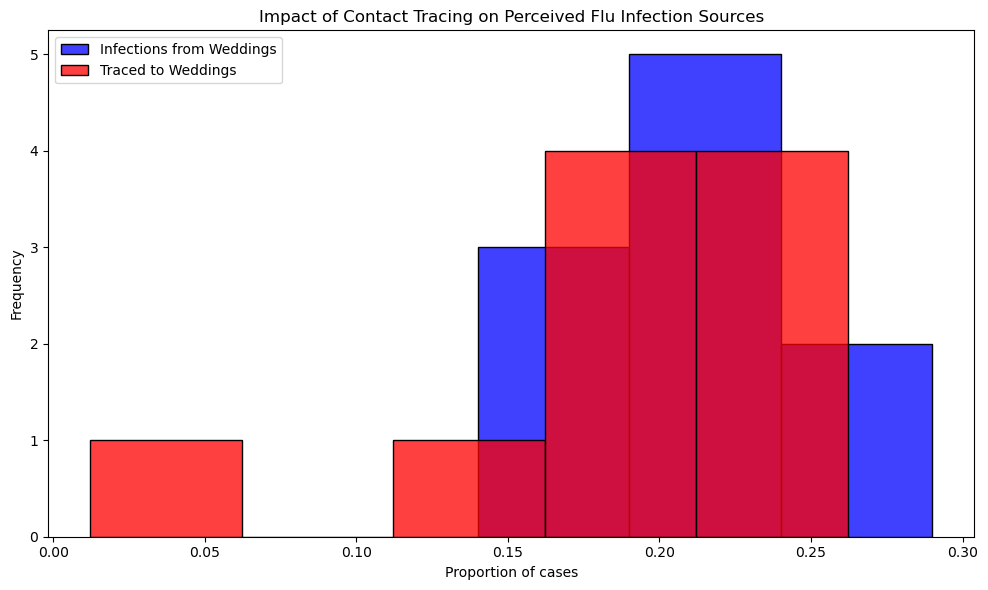

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': np.nan  # Initially setting traced status as NaN
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)

  return p_wedding_infections, p_wedding_traces

# Set random seed for reproducibility
np.random.seed(9999)

# Run the simulation 1000 times
results = [simulate_event(m) for m in range(10)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()

## Criteria

|Criteria|Complete|Incomplete|
|--------|----|----|
|Alteration of the code|The code changes made, made it reproducible.|The code is still not reproducible.|
|Description of changes|The author answered questions and explained the reasonings for the changes made well.|The author did not answer questions or explain the reasonings for the changes made well.|

## Submission Information
🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `23:59 - 06 January 2026`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This markdown file (`a1_sampling_and_reproducibility.ipynb`) should be populated with the code changed.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/sampling/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

#### Checklist:
- [ ] Create a branch called `assignment-1`.
- [ ] Ensure that the repository is public.
- [ ] Review [the PR description guidelines](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md#guidelines-for-pull-request-descriptions) and adhere to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via the help channel in Slack. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
